# RSA Alignment Hemisphere Comparison  

Compare RSA alignment across left vs. right hemispheres for inter‑subject and subject‑model comparisons.


## 0. Imports & Setup  
Load standard libraries (path handling, data frames, plotting, stats) and project utilities for figure styling and alignment processing. Initialize fonts.


In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel, pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests

# Reused import for the project
from convergence.figures import add_pvalue_bracket, setup_matplotlib_fonts
from convergence.figures_utils import add_cluster, process_intersubject_rois, proccess_alignment

setup_matplotlib_fonts()

## 1. Data Paths & Validation  
Define paths to derivatives folder, HCP atlas metadata, model information, and RSA results for subject‑subject and subject‑model alignments (both joined and separated hemispheres). Create output directory and assert that all required files exist.


In [2]:
# Required filenames for the figures
data_folder = Path("../derivatives")
hcp_filename = data_folder / "metadata" / "hcp.csv"
models_filename = data_folder / "metadata" / "models-info.csv"
nsd_folder = data_folder / "nsd"
pvalues_filename = nsd_folder / "rsa_pvalues_subject_language_vision.parquet"
intersubject_shift1_joined_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_joined.parquet"
)
intersubject_shift1_separated_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_separated.parquet"
)
model_brain_joined_filename = nsd_folder / "rsa_subject_model_alignment_joined.parquet"
model_brain_separated_filename = nsd_folder / "rsa_subject_model_alignment_separated.parquet"

# Output folder for figures
figure_folder = Path("../figures")
output = figure_folder / "02_rsa_hemisphere_comparison"
output.mkdir(exist_ok=True, parents=True)

Test needed files exist before running the notebook.

In [3]:
for filename in (
    data_folder,
    hcp_filename,
    models_filename,
    intersubject_shift1_joined_filename,
    intersubject_shift1_separated_filename,
    model_brain_joined_filename,
    model_brain_separated_filename,
):
    assert filename.exists(), f"File {filename} does not exist. Please check the path."

## 2. Per‑ROI Hemisphere Comparison  
Compute left vs. right hemisphere RSA for each ROI, perform paired t‑tests across subjects, and correct p‑values.


### 2.1 Scatterplot Panels  
Plot three side‑by‑side scatterplots of LH vs. RH RSA for:  
1. Inter‑subject alignment  
2. Vision model–brain alignment  
3. Language model–brain alignment  
— Color top areas distinctly, style significant vs. non‑significant points, add unity line  
— Format axes, add labels, and save as SVG

In [4]:
df_comparison_separated_subjects = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_separated_filename,
    subject_alignment_filename=intersubject_shift1_separated_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=False,
)

columns = [
    "roi",
    "subject",
    "intersubject_rsa",
    "language_rsa",
    "vision_rsa",
    "intersubject_p_value",
]
df_comparison_separated_subjects_lh = (
    df_comparison_separated_subjects[columns].query("roi<=180").copy()
)
df_comparison_separated_subjects_rh = (
    df_comparison_separated_subjects[columns].query("roi>180").copy()
)
rh_mapping = {
    "intersubject_rsa": "intersubject_rsa_rh",
    "language_rsa": "language_rsa_rh",
    "vision_rsa": "vision_rsa_rh",
}
df_comparison_separated_subjects_rh = df_comparison_separated_subjects_rh.rename(columns=rh_mapping)
df_comparison_separated_subjects_rh = df_comparison_separated_subjects_rh.drop(
    columns="intersubject_p_value"
)
df_comparison_separated_subjects_rh.roi = df_comparison_separated_subjects_rh.roi - 180
lh_mapping = {
    "intersubject_rsa": "intersubject_rsa_lh",
    "language_rsa": "language_rsa_lh",
    "vision_rsa": "vision_rsa_lh",
}
df_comparison_separated_subjects_lh = df_comparison_separated_subjects_lh.rename(columns=lh_mapping)
df_comparison_separated_hemispheres_subjects = df_comparison_separated_subjects_lh.merge(
    df_comparison_separated_subjects_rh, on=["roi", "subject"]
)


# Functions for paired t-tests
def paired_ttest(group, col_lh, col_rh):
    t_stat, p_val = ttest_rel(group[col_lh], group[col_rh])
    return pd.Series({f"t_stat_{col_lh[:-3]}": t_stat, f"p_value_{col_lh[:-3]}": p_val})


# Perform groupby and apply t-tests separately
results_intersubject = df_comparison_separated_hemispheres_subjects.groupby("roi").apply(
    paired_ttest, "intersubject_rsa_lh", "intersubject_rsa_rh", include_groups=False
)

results_vision = df_comparison_separated_hemispheres_subjects.groupby("roi").apply(
    paired_ttest, "vision_rsa_lh", "vision_rsa_rh", include_groups=False
)

results_language = df_comparison_separated_hemispheres_subjects.groupby("roi").apply(
    paired_ttest, "language_rsa_lh", "language_rsa_rh", include_groups=False
)

# Merge all results into a single dataframe
results_df = pd.concat(
    [results_intersubject, results_vision, results_language], axis=1
).reset_index()
results_df
# # Correct for multiple comparisons (FDR) for each modality separately
for p_value_modality in ["p_value_intersubject_rsa", "p_value_vision_rsa", "p_value_language_rsa"]:
    corrected = multipletests(results_df[p_value_modality], method="fdr_bh")[1]
    results_df[f"corrected_{p_value_modality}"] = corrected


results_df

,roi,t_stat_intersubject_rsa,p_value_intersubject_rsa,t_stat_vision_rsa,p_value_vision_rsa,t_stat_language_rsa,p_value_language_rsa,corrected_p_value_intersubject_rsa,corrected_p_value_vision_rsa,corrected_p_value_language_rsa
0,1,3.386236,0.011659,2.454404,0.043823,-1.040413,0.332744,0.072594,0.315528,0.750276
1,2,-2.978682,0.020553,-1.114396,0.301903,-1.293093,0.237016,0.087387,0.574642,0.670103
2,3,-0.732282,0.487784,-0.501618,0.631325,-0.197528,0.849027,0.622704,0.800271,0.931859
3,4,4.306593,0.003538,1.769171,0.120182,1.023360,0.340196,0.035379,0.464087,0.750276
4,5,4.114241,0.004492,1.788731,0.116794,-1.639653,0.145085,0.038076,0.464087,0.609694
...,...,...,...,...,...,...,...,...,...,...
175,176,-3.039053,0.018872,-0.866885,0.414730,-1.489436,0.179985,0.087387,0.644242,0.639705
176,177,-2.251232,0.059091,-0.524199,0.616324,0.147413,0.886962,0.180736,0.786797,0.939136
177,178,-2.043688,0.080275,-1.673123,0.138219,-0.961645,0.368261,0.212677,0.492168,0.750276
178,179,-0.847237,0.424879,-1.114226,0.301972,0.126136,0.903171,0.578600,0.574642,0.939715


Per modality (intersubject, vision models, language models) alignment comparison to brain areas.

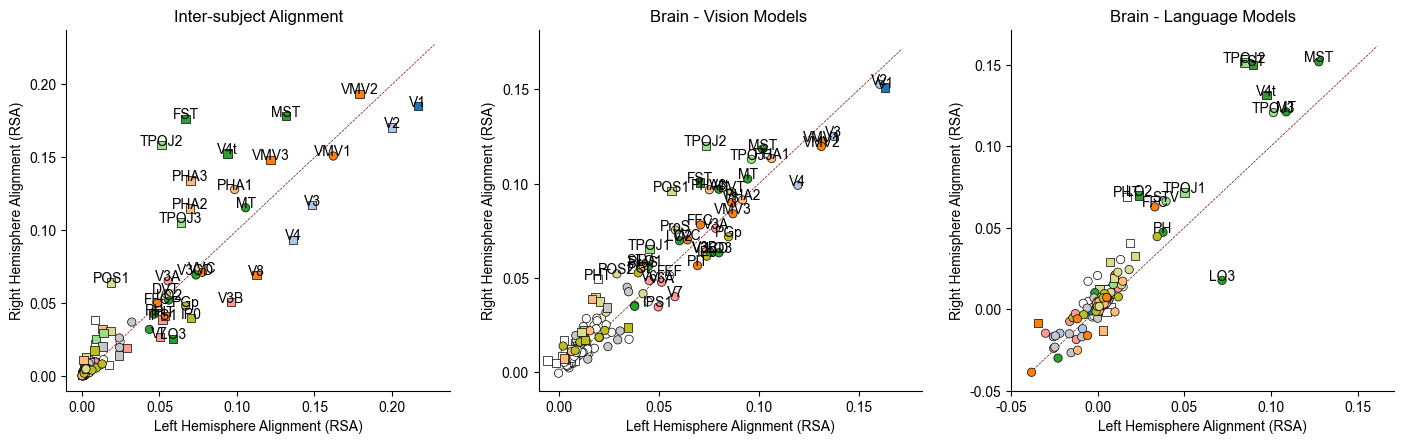

In [5]:
df_comparison_separated = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_separated_filename,
    subject_alignment_filename=intersubject_shift1_separated_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=True,
)


df_comparison_separated_lh = (
    df_comparison_separated[
        ["roi", "intersubject_rsa", "language_rsa", "vision_rsa", "intersubject_p_value"]
    ]
    .query("roi<=180")
    .copy()
)
df_comparison_separated_rh = (
    df_comparison_separated[
        ["roi", "intersubject_rsa", "language_rsa", "vision_rsa", "intersubject_p_value"]
    ]
    .query("roi>180")
    .copy()
)
df_comparison_separated_rh = df_comparison_separated_rh.rename(
    columns={
        "intersubject_rsa": "intersubject_rsa_rh",
        "language_rsa": "language_rsa_rh",
        "vision_rsa": "vision_rsa_rh",
    }
)
df_comparison_separated_rh = df_comparison_separated_rh.drop(columns="intersubject_p_value")
df_comparison_separated_rh.roi = df_comparison_separated_rh.roi - 180
df_comparison_separated_lh = df_comparison_separated_lh.rename(
    columns={
        "intersubject_rsa": "intersubject_rsa_lh",
        "language_rsa": "language_rsa_lh",
        "vision_rsa": "vision_rsa_lh",
    }
)
df_comparison_separated_hemispheres = df_comparison_separated_lh.merge(
    df_comparison_separated_rh, on="roi"
)
hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name", "mne_name", "area", "area_color"]]
df_comparison_separated_hemispheres = df_comparison_separated_hemispheres.merge(hcp, on="roi")
df_comparison_separated_hemispheres = df_comparison_separated_hemispheres.query(
    "intersubject_p_value < 0.05"
).copy()

area_order = (
    df_comparison_separated_hemispheres.sort_values("area").drop_duplicates("area").area.tolist()
)
palette = (
    df_comparison_separated_hemispheres.sort_values("area")
    .drop_duplicates("area")
    .area_color.tolist()
)
whites = ["white"] * len(palette)

df_subject = pd.read_parquet(intersubject_shift1_joined_filename)
top_areas = process_intersubject_rois(df_subject, hcp_filename=hcp_filename, top=10).area.unique()

s = 4.8
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * s, s))


level = 0.05
df_comparison_separated_hemispheres["intersubject_significant"] = (
    results_df["p_value_intersubject_rsa"] < level
).map({True: "Significant", False: "Not Significant"})
df_comparison_separated_hemispheres["vision_significant"] = (
    results_df["p_value_vision_rsa"] < level
).map({True: "Significant", False: "Not Significant"})
df_comparison_separated_hemispheres["language_significant"] = (
    results_df["p_value_language_rsa"] < level
).map({True: "Significant", False: "Not Significant"})

style_order = {"Significant": "s", "Not Significant": "o"}


sns.scatterplot(
    data=df_comparison_separated_hemispheres.query("area not in @top_areas"),
    x="intersubject_rsa_lh",
    y="intersubject_rsa_rh",
    hue="area",
    palette=whites,
    ax=ax1,
    legend=False,
    edgecolor="black",
    linewidth=0.5,
    hue_order=area_order,
    style="intersubject_significant",
    markers=style_order,
)
sns.scatterplot(
    data=df_comparison_separated_hemispheres.query("area in @top_areas"),
    x="intersubject_rsa_lh",
    y="intersubject_rsa_rh",
    hue="area",
    palette=palette,
    ax=ax1,
    legend=False,
    edgecolor="black",
    linewidth=0.5,
    hue_order=area_order,
    style="intersubject_significant",
    markers=style_order,
)

sns.scatterplot(
    data=df_comparison_separated_hemispheres.query("area not in @top_areas"),
    x="vision_rsa_lh",
    y="vision_rsa_rh",
    hue="area",
    palette=whites,
    legend=False,
    ax=ax2,
    edgecolor="black",
    linewidth=0.5,
    hue_order=area_order,
    style="vision_significant",
    markers=style_order,
)
sns.scatterplot(
    data=df_comparison_separated_hemispheres.query("area in @top_areas"),
    x="vision_rsa_lh",
    y="vision_rsa_rh",
    hue="area",
    palette=palette,
    legend=False,
    ax=ax2,
    edgecolor="black",
    linewidth=0.5,
    hue_order=area_order,
    style="vision_significant",
    markers=style_order,
)


sns.scatterplot(
    data=df_comparison_separated_hemispheres.query("area not in @top_areas"),
    x="language_rsa_lh",
    y="language_rsa_rh",
    hue="area",
    palette=whites,
    legend=False,
    ax=ax3,
    edgecolor="black",
    linewidth=0.5,
    hue_order=area_order,
    style="language_significant",
    markers=style_order,
)
sns.scatterplot(
    data=df_comparison_separated_hemispheres.query("area in @top_areas"),
    x="language_rsa_lh",
    y="language_rsa_rh",
    hue="area",
    palette=palette,
    legend=False,
    ax=ax3,
    edgecolor="black",
    linewidth=0.5,
    hue_order=area_order,
    style="language_significant",
    markers=style_order,
)

p_values = ["", "corrected_p_value_vision_rsa", "corrected_p_value_language_rsa"]

for i, ax in enumerate([ax1, ax2, ax3]):
    # Get xlim and y lim and set the same (from 0 to max of both)
    eps = 0.01
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    max_value = max(xlim[1], ylim[1])
    if i < 2:
        ax.set_xlim(0 - eps, max_value + eps)
        ax.set_ylim(0 - eps, max_value + eps)
        ax.plot(
            [0, max_value],
            [0, max_value],
            color="maroon",
            linestyle="--",
            linewidth=0.5,
            zorder=-100,
        )
    else:
        ax.set_xlim(-0.04 - eps, max_value + eps)
        ax.set_ylim(-0.04 - eps, max_value + eps)
        ax.plot(
            [-0.04, max_value],
            [-0.04, max_value],
            color="maroon",
            linestyle="--",
            linewidth=0.5,
            zorder=-100,
        )
    sns.despine(ax=ax)

    ax.set_xlabel("Left Hemisphere Alignment (RSA)")
    ax.set_ylabel("Right Hemisphere Alignment (RSA)")
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.05))

ax1.set_title("Inter-subject Alignment")
ax2.set_title("Brain - Vision Models ")
ax3.set_title("Brain - Language Models")

# Add text in scatters as labels of dots if intersubject_rsa_lh > 0.05 or intersubject_rsa_rh > 0.05 (same vision and language)
for ax, modality in zip([ax1, ax2, ax3], ["intersubject_rsa", "vision_rsa", "language_rsa"]):
    for i, row in df_comparison_separated_hemispheres.iterrows():
        if row[f"{modality}_lh"] > 0.045 or row[f"{modality}_rh"] > 0.045:
            ax.text(row[f"{modality}_lh"], row[f"{modality}_rh"], row["name"], ha="center")

# Add pad between subplots
plt.tight_layout(pad=2.0)

fig.savefig(
    output / "01_rsa_hemispheres_comparison.svg", bbox_inches="tight", dpi=300, transparent=True
)

Correlations of hemisphere. Check if preserve a similar order

In [6]:
# Spearman corr

print(
    spearmanr(
        df_comparison_separated_hemispheres.intersubject_rsa_lh,
        df_comparison_separated_hemispheres.intersubject_rsa_rh,
    )
)
print(
    spearmanr(
        df_comparison_separated_hemispheres.vision_rsa_lh,
        df_comparison_separated_hemispheres.vision_rsa_rh,
    )
)
print(
    spearmanr(
        df_comparison_separated_hemispheres.language_rsa_lh,
        df_comparison_separated_hemispheres.language_rsa_rh,
    )
)

SignificanceResult(statistic=np.float64(0.9304355645966546), pvalue=np.float64(1.82078606819449e-69))
SignificanceResult(statistic=np.float64(0.9237808470655362), pvalue=np.float64(1.667472350783365e-66))
SignificanceResult(statistic=np.float64(0.8222576423818059), pvalue=np.float64(8.82685559483811e-40))


### 2.2 Legends  
Generate standalone legends for:  
— Marker styles (significant vs. non‑significant)  
— Top anatomical areas vs. “Other Areas”

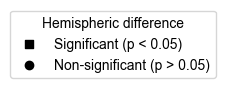

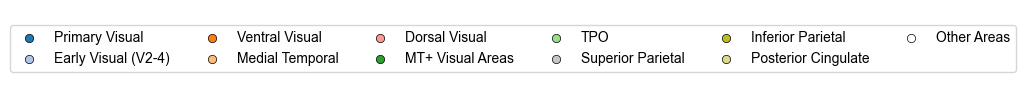

In [7]:
# Create a legend with black scatter one o and other squared with Significant and non-significant and title t(7) paired t-test
fig, ax = plt.subplots(figsize=(2, 1))
ax.scatter([], [], marker="s", color="black", label="Significant (p < 0.05)")
ax.scatter([], [], marker="o", color="black", label="Non-significant (p > 0.05)")
ax.legend(title="Hemispheric difference", loc="center")
ax.axis("off")  # Hide the axes
fig.tight_layout()
fig.savefig(output / "01_legend_significant.pdf", bbox_inches="tight", dpi=300, transparent=True)


# top_areas
hcp = pd.read_csv(hcp_filename)
areas = (
    hcp.query("area in @top_areas")
    .drop_duplicates("area")
    .sort_values("area_id")[["area", "area_color"]]
    .set_index("area")
    .to_dict()["area_color"]
)

# Make a legend with the top areas as scatter
fig, ax = plt.subplots(figsize=(2, 1))
for area, color in areas.items():
    ax.scatter([], [], marker="o", color=color, label=area, linewidths=0.5, edgecolor="black")

# Add other areas white
ax.scatter(
    [], [], marker="o", color="white", label="Other Areas", linewidths=0.5, edgecolor="black"
)

ax.legend(title="", loc="center", ncol=6)
ax.axis("off")  # Hide the axes

fig.savefig(output / "01_legend_areas_top.pdf", bbox_inches="tight", dpi=300, transparent=True)

## 3. Hub‑Based Hemisphere Asymmetries  
Compare LH vs. RH RSA within predefined clusters (Visual Cortex, Ventral Hub, Dorsal Hub).


,cluster,comparison,t_stat,p_value,mean_diff,p_corrected,apa_significance,modality
0,Visual Cortex,intersubject_rsa_lh vs intersubject_rsa_rh,6.337774,0.000390,0.033805,0.00091,***,intersubject
1,Ventral Hub,intersubject_rsa_lh vs intersubject_rsa_rh,-6.509373,0.000331,-0.028160,0.00091,***,intersubject
2,Dorsal Hub,intersubject_rsa_lh vs intersubject_rsa_rh,-10.006456,0.000021,-0.062219,0.00015,***,intersubject
3,Visual Cortex,vision_rsa_lh vs vision_rsa_rh,2.590001,0.035945,0.013143,0.04194,*,vision
4,Ventral Hub,vision_rsa_lh vs vision_rsa_rh,-0.083793,0.935567,-0.000663,0.93557,n.s.,vision
5,Dorsal Hub,vision_rsa_lh vs vision_rsa_rh,-3.557691,0.009248,-0.022442,0.01295,*,vision
6,Dorsal Hub,language_rsa_lh vs language_rsa_rh,-5.398607,0.001010,-0.035936,0.00177,**,language


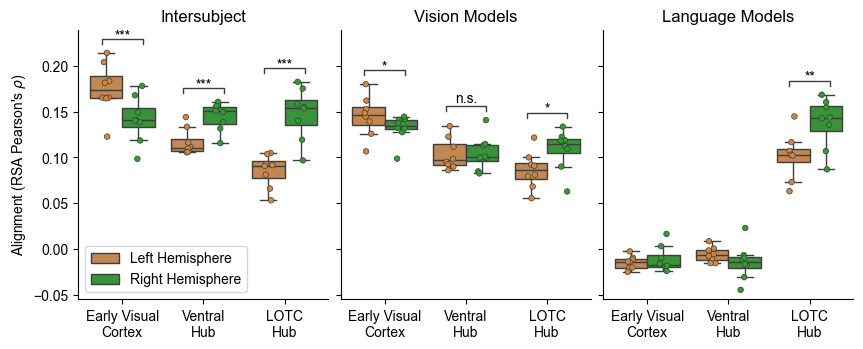

In [8]:
hcp = pd.read_csv(hcp_filename)

df_hemispheres_clusters = add_cluster(
    df_comparison_separated_hemispheres_subjects.merge(
        hcp[["roi", "name", "mne_name", "area", "area_color"]], on="roi"
    )
)

df_hemispheres_clusters.cluster = df_hemispheres_clusters.cluster.str.replace("Cluster", "Hub")
df_hemispheres_clusters = df_hemispheres_clusters.query("cluster != 'Other'").copy()
df_hemispheres_clusters = (
    df_hemispheres_clusters.groupby(["cluster", "subject"])
    .aggregate(
        {
            "language_rsa_lh": "mean",
            "language_rsa_rh": "mean",
            "vision_rsa_lh": "mean",
            "vision_rsa_rh": "mean",
            "intersubject_rsa_lh": "mean",
            "intersubject_rsa_rh": "mean",
        }
    )
    .reset_index()
)

# Unpivot the dataframe. Index: cluster and subject. Columns: modality. Values: score
df_hemispheres_clusters = df_hemispheres_clusters.melt(
    id_vars=["cluster", "subject"], var_name="modality", value_name="score"
).copy()
# Add hemisphere (last split _ of modality)
# Add modality (First split _ of modality)
df_hemispheres_clusters["hemisphere"] = (
    df_hemispheres_clusters.modality.str.split("_")
    .str[-1]
    .replace({"lh": "Left Hemisphere", "rh": "Right Hemisphere"})
)
df_hemispheres_clusters["modality"] = df_hemispheres_clusters.modality.str.split("_").str[0]


# 3 subplots. hue is hemisphere, x is cluster, y is score, cols is modality
# Reduce the horizontal spacing for joining the plots
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, gridspec_kw={"wspace": 0.05})
# Set order of clusters
order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
# Set order of modalities
modality_order = ["intersubject", "vision", "language"]
# Set order of hemispheres
hemisphere_order = ["Left Hemisphere", "Right Hemisphere"]

# Set palette
palette = ["#D48640", "#2ca02c"]


# Perform all pairwise t-tests for each cluster
# Define comparisons explicitly
comparions = [
    ("Visual Cortex", "intersubject_rsa_lh", "intersubject_rsa_rh"),
    ("Ventral Hub", "intersubject_rsa_lh", "intersubject_rsa_rh"),
    ("Dorsal Hub", "intersubject_rsa_lh", "intersubject_rsa_rh"),
    ("Visual Cortex", "vision_rsa_lh", "vision_rsa_rh"),
    ("Ventral Hub", "vision_rsa_lh", "vision_rsa_rh"),
    ("Dorsal Hub", "vision_rsa_lh", "vision_rsa_rh"),
    # ("Visual Cortex", "language_rsa_lh", "language_rsa_rh"),
    # ("Ventral Hub", "language_rsa_lh", "language_rsa_rh"),
    ("Dorsal Hub", "language_rsa_lh", "language_rsa_rh"),
]
results = []
for cluster, cond1, cond2 in comparions:
    modality = cond1.split("_")[0]
    subset = df_hemispheres_clusters.query("cluster == @cluster and modality == @modality")
    left_subset = subset.query("hemisphere == 'Left Hemisphere'")
    right_subset = subset.query("hemisphere == 'Right Hemisphere'")
    t_stat, p_value = ttest_rel(left_subset["score"], right_subset["score"])
    mean_diff = left_subset["score"].mean() - right_subset["score"].mean()

    results.append(
        {
            "cluster": cluster,
            "comparison": f"{cond1} vs {cond2}",
            "t_stat": t_stat,
            "p_value": p_value,
            "mean_diff": mean_diff,
        }
    )

# Convert to dataframe
results_df_cluster = pd.DataFrame(results)

# Corrected p-values (FDR correction)
results_df_cluster["p_corrected"] = multipletests(results_df_cluster["p_value"], method="fdr_bh")[
    1
].round(5)
results_df_cluster["apa_significance"] = results_df_cluster["p_corrected"].apply(
    lambda x: "*" * int(-np.log10(x)) if x < 0.05 else "n.s."
)
results_df_cluster["modality"] = results_df_cluster["comparison"].str.split("_").str[0]


for i, (ax, modality) in enumerate(zip(axes, modality_order)):
    sns.boxplot(
        data=df_hemispheres_clusters.query("modality == @modality"),
        x="cluster",
        y="score",
        hue="hemisphere",
        ax=ax,
        order=order,
        hue_order=hemisphere_order,
        palette=palette,
        legend=i == 0,
        showfliers=False,
    )
    # Plot individual points with jitter
    sns.stripplot(
        data=df_hemispheres_clusters.query("modality == @modality"),
        x="cluster",
        y="score",
        hue="hemisphere",
        ax=ax,
        order=order,
        hue_order=hemisphere_order,
        palette=palette,
        dodge=True,
        alpha=1,
        linewidth=0.5,
        size=4,
        jitter=True,
        edgecolor=(0.24, 0.24, 0.24),
        zorder=100,
        legend=False,
    )
    ax.set_xlabel("")
    ax.set_ylim(-0.055, 0.24)
    sns.despine(ax=ax)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["Early Visual\nCortex", "Ventral\nHub", "LOTC\nHub"])

    # Add p-value brackets
    for j, cluster in enumerate(order):
        # Get the p-value for the current cluster and modality
        p_value = results_df_cluster.query("cluster == @cluster and modality == @modality")[
            "p_corrected"
        ]
        if not p_value.empty:
            max_value = df_hemispheres_clusters.query(
                "modality == @modality and cluster == @cluster"
            )["score"].max()
            text = results_df_cluster.query("cluster == @cluster and modality == @modality")[
                "apa_significance"
            ].values[0]
            margin = 0.02 if text == "n.s." else 0.015
            # Add the p-value bracket
            add_pvalue_bracket(
                ax=ax,
                x1=j - 0.25,
                x2=j + 0.25,
                y=max_value + 0.01,
                height=0.005,
                text=text,
                y_text=max_value + margin,
            )

    if i == 0:
        ax.set_ylabel(r"Alignment (RSA Pearson's $\rho$)")
        ax.set_title("Intersubject")
        # Remove legend title
        ax.legend(title="", loc="lower left")

    else:
        ax.set_ylabel("")
        ax.set_title(modality.capitalize() + " Models")

        # ax.set_yticks([])


fig.savefig(
    output / "02_rsa_hemispheres_clusters_boxplot.pdf", bbox_inches="tight", dpi=300, transparent=True
)


results_df_cluster

## 4. Cross‑hemisphere vs. Bilateral RSA Comparison  
Assess how cross‑hemisphere RSA (LH of subject p vs. RH of subject q) relates to bilateral RSA (LH+RH combined).


In [9]:
df = pd.read_parquet(intersubject_shift1_separated_filename)
df_joined = pd.read_parquet(intersubject_shift1_joined_filename)
hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name", "area"]]

df_left = (
    df.query("subject_i != subject_j and (roi_x == roi_y) and roi_x <= 180")
    .groupby(["roi_x"])
    .similarity.mean()
    .reset_index()
)
df_left = df_left.rename(columns={"roi_x": "roi_lh", "similarity": "similarity_lh"})
df_right = (
    df.query("subject_i != subject_j and (roi_x == roi_y) and roi_x > 180")
    .groupby(["roi_x"])
    .similarity.mean()
    .reset_index()
)
df_right = df_right.rename(columns={"roi_x": "roi_rh", "similarity": "similarity_rh"})


df_comp = df.query("subject_i != subject_j and (roi_x + 180 == roi_y)")
df_comp = df_comp.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
df_comp = df_comp.rename(
    columns={"roi_x": "roi_lh", "similarity": "similarity_comp", "roi_y": "roi_rh"}
)
df_hemispheres = df_comp.merge(df_left, on="roi_lh").merge(df_right, on="roi_rh")

df_hemispheres = df_hemispheres.sort_values("similarity_comp", ascending=False).reset_index(
    drop=True
)

df_joined = (
    df_joined.query("roi_x == roi_y and subject_i != subject_j")
    .groupby(["roi_x"])
    .similarity.mean()
    .reset_index()
)
df_joined = df_joined.rename(columns={"roi_x": "roi_lh", "similarity": "similarity_joined"})

df_hemispheres = df_hemispheres.merge(df_joined)
df_hemispheres = df_hemispheres.merge(hcp, left_on="roi_lh", right_on="roi").drop(columns=["roi"])
df_hemispheres = df_hemispheres.rename(columns={"roi_lh": "roi"}).drop(columns=["roi_rh"])
df_hemispheres = df_hemispheres[
    [
        "roi",
        "name",
        "similarity_lh",
        "similarity_rh",
        "similarity_comp",
        "similarity_joined",
        "area",
    ]
]
df_hemispheres

,roi,name,similarity_lh,similarity_rh,similarity_comp,similarity_joined,area
0,160,VMV2,0.179035,0.193493,0.179450,0.213400,Ventral Visual
1,153,VMV1,0.162132,0.150945,0.152725,0.185176,Ventral Visual
2,2,MST,0.131582,0.178245,0.151619,0.210775,MT+ Visual Areas
3,1,V1,0.216566,0.185160,0.150955,0.194511,Primary Visual
4,4,V2,0.200117,0.170510,0.132089,0.177940,Early Visual (V2-4)
...,...,...,...,...,...,...,...
175,112,AAIC,0.000395,0.000143,0.000105,0.000275,Insula & Frontal Operculum
176,102,OP2-3,-0.000420,0.000623,0.000102,-0.000172,Opercular
177,174,LBelt,0.000020,0.000036,0.000033,-0.000232,Auditory
178,164,25,0.000081,0.000154,0.000014,0.000110,Anterior Cingulate & mPFC


In [10]:
# Compute correlation and p-value of similarity_comp vs similarity_joined
corr, p_value = pearsonr(df_hemispheres["similarity_comp"], df_hemispheres["similarity_joined"])
print(f"Correlation: {corr:.3f}, p-value: {p_value:.3f}")

Correlation: 0.992, p-value: 0.000


Comparison of inter-subject alignment of
- Left+Right hemisphere of one subject vs Left+Right hemisphere of another subject
- Left hemisphere of one subject vs Right hemisphere of another subject

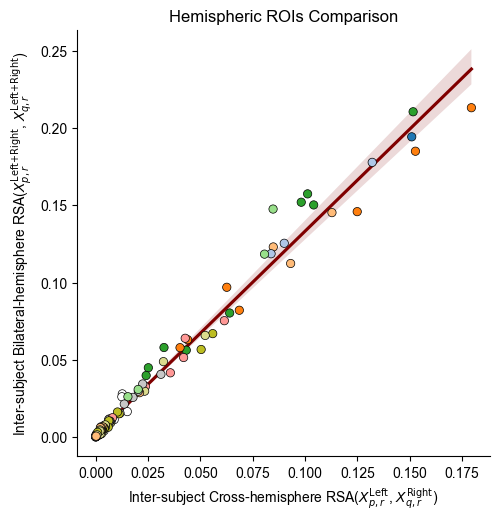

In [11]:
palette = df_comparison_separated_hemispheres.sort_values("area").drop_duplicates("area").area_color.tolist()
whites = ["white"] * len(palette)

g = sns.lmplot(
    data=df_hemispheres,
    x="similarity_comp",
    y="similarity_joined",
    scatter=False,
    line_kws={"color": "maroon", "zorder": -100},
)
ax = g.ax
sns.scatterplot(
    data=df_hemispheres.query("area not in @top_areas"),
    x="similarity_comp",
    y="similarity_joined",
    palette=whites,
    hue="area",
    legend=False,
    hue_order=area_order,
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
)
g = sns.scatterplot(
    data=df_hemispheres.query("area in @top_areas"),
    x="similarity_comp",
    y="similarity_joined",
    palette=palette,
    hue="area",
    legend=False,
    hue_order=area_order,
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
)

ax.set_xlabel(
    "Inter-subject Cross-hemisphere RSA($X_{p,r}^{\\text{Left}}$, $X_{q,r}^{\\text{Right}}$)"
)
ax.set_ylabel(
    "Inter-subject Bilateral-hemisphere RSA($X_{p,r}^{\\text{Left+Right}}$, $X_{q,r}^{\\text{Left+Right}}$)"
)
ax.set_title("Hemispheric ROIs Comparison")
g.figure.savefig(
    output / "03_rsa_hemispheres_cross_subject_comparison.pdf", bbox_inches="tight", transparent=True
)